In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

az.style.use("arviz-darkgrid")


HOWELL1_DATA_LOCATION = '../../data/howell1.csv' 

In [2]:
df = pd.read_csv(HOWELL1_DATA_LOCATION)
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Relationship Between Height and Weight

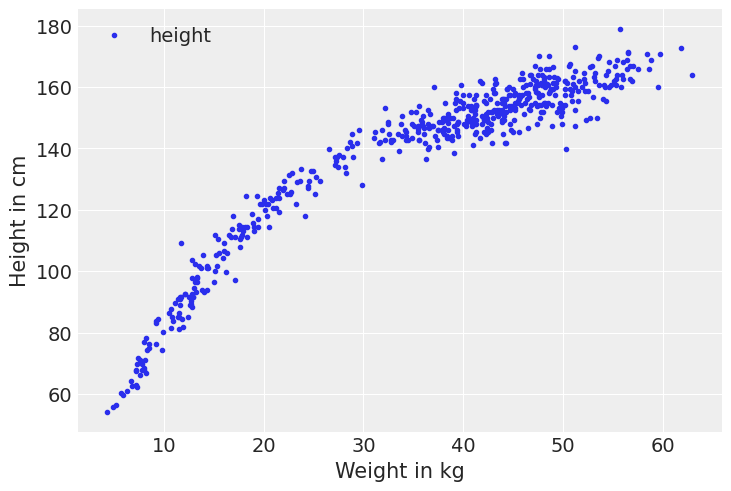

In [3]:
df.plot(x='weight', y='height', style='.')

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

plt.show()

## Parabolic Model for Height vs Weight

We first standardize the weight. To this end, define $z_i = (x_i - \bar{x}) / \text{sd}(x)$. The model is defined as follows:
$$
\begin{align*}
    h_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_1 \cdot z_i + \beta_2 \cdot z_i^2 \\
    \alpha  & \sim N(178, 20) \\
    \beta_1 & \sim \text{Lognormal}(0, 1) \\
    \beta_2 & \sim N(0, 1) \\
    \sigma  & \sim \text{Uniform}(0, 50)
\end{align*}
$$

In [4]:
z = (df['weight'] - df['weight'].mean()) / df['weight'].std()
z_sq = z**2

with pm.Model() as m_poly:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta_1 = pm.Lognormal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    mu = pm.Deterministic('mu', alpha + beta_1 * z + beta_2 * z_sq)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    trace_poly = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_2, beta_1, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


### Code 4.66

In [5]:
az.summary(trace_poly, var_names=['alpha', 'beta_1', 'beta_2', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,146.059,0.370,145.441,146.624,0.006,0.004,3689.0,3689.0,3691.0,4742.0,1.0
beta_1,21.731,0.291,21.302,22.233,0.004,0.003,4345.0,4345.0,4344.0,4929.0,1.0
beta_2,-7.802,0.275,-8.238,-7.354,0.005,0.003,3616.0,3615.0,3615.0,4611.0,1.0
sigma,5.796,0.178,5.519,6.087,0.002,0.002,6095.0,6095.0,6076.0,4994.0,1.0


### Code 4.67 and Code 4.68

In [6]:
df_trace = pm.trace_to_dataframe(trace_poly)
df_mu = df_trace.filter(regex=('mu.*'))

df_mu.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__534,mu__535,mu__536,mu__537,mu__538,mu__539,mu__540,mu__541,mu__542,mu__543
0,158.578978,147.318926,140.052371,160.622728,153.215568,159.041298,149.675790,160.900333,144.954183,160.839446,...,158.094744,107.616037,75.140845,143.990756,77.919553,138.749884,160.416815,160.791464,78.017947,160.509995
1,158.469903,147.101753,139.856170,160.639514,153.016406,159.431227,149.460524,160.992396,144.740063,160.899608,...,157.970721,107.724784,75.691862,143.779046,78.429811,138.560510,160.409035,160.838486,78.526769,160.512350
2,158.871694,147.872670,140.604496,160.668922,153.704967,158.396249,150.213735,160.803980,145.514472,160.803206,...,158.417988,107.764790,74.629020,144.551525,77.469720,139.295969,160.510124,160.780105,77.570294,160.583820
3,158.055983,147.232123,140.064431,159.806713,152.978033,157.504890,149.539392,159.927402,144.907146,159.931910,...,157.611235,107.643999,74.909050,143.957573,77.715858,138.773489,159.654244,159.911310,77.815230,159.725213
4,158.899018,147.498053,140.227744,161.070429,153.431400,159.842344,149.864503,161.421280,145.128464,161.329539,...,158.398828,107.977721,75.820663,144.164183,78.569347,138.927532,160.840234,161.268773,78.666685,160.943459


In [7]:
mu_mean = df_mu.apply(np.mean, axis=0)

In [8]:
ht_sim = pm.sampling.sample_posterior_predictive(trace=trace_poly, samples=5000, model=m_poly)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


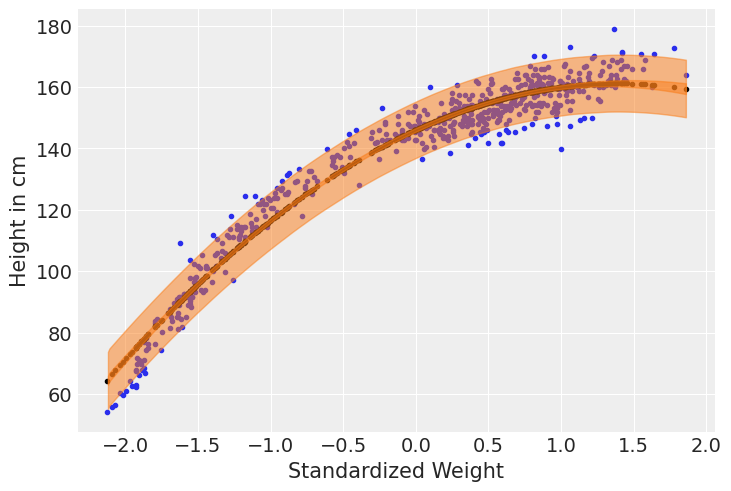

In [9]:
ht_simulated = ht_sim['height']
ht = df['height']
wt = z

_, ax = plt.subplots()

# Raw data
ax.scatter(wt, ht, marker='.')

# Mean mu values as function of weight
ax.scatter(wt, mu_mean, color='k', marker='.')

# Plot the hpd intervals for the height 
az.plot_hdi(wt, np.expand_dims(ht_simulated, 0), hdi_prob=0.89, ax=ax)

# Plot the hpd intervals for the mu values
az.plot_hdi(wt, np.expand_dims(df_mu.values, 0), hdi_prob=0.89, ax=ax)

plt.xlabel('Standardized Weight')
plt.ylabel('Height in cm')

plt.show()